Author: Mark McDonnell, mark.mcdonnell@unisa.edu.au

This notebook demonstrates traning and validation on the official DCASE 2020 Task 1b train and validation sets

In [2]:
model_name = 'McDonnell_Task1b_dev_train_val' 

In [15]:
#select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

#imports 
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from scipy.io import savemat,loadmat
import soundfile as sound
import librosa
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.optimizers import SGD

print("keras version = ",tensorflow.keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

sys.path.insert(0, "../")
from NNets import model_resnet_DCASE2020_Task1b
from DCASE_training_functions import LR_WarmRestart, MixupGenerator
from DCASE_plots import plot_confusion_matrix

keras version =  2.2.4-tf
tensorflow version =  1.13.1


In [4]:
#source data attributes
sr = 48000
num_audio_channels = 2
SampleDuration = 10 #seconds

#log-mel spectrogram parameters
NumFreqBins = 256
NumFFTPoints = 4096
HopLength = int(NumFFTPoints/4)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

#training parameters
init_lr = 0.025
batch_size = 32
num_epochs = 310
mixup_alpha = 0.4
crop_length = 400

#model parameters
wd = 5e-4
num_filters=26

In [5]:
#class information
meta_df = pd.read_csv('../../Data/TAU-urban-acoustic-scenes-2020-3class-development/meta.csv',sep='\t', encoding='ASCII')
ClassNames = np.unique(meta_df['scene_label'])
NumClasses = len(ClassNames)
print('Classes=',ClassNames)

#get info on official train-dev split:
BasePath = '../../Data/TAU-urban-acoustic-scenes-2020-3class-development/'
TrainFile = BasePath + 'evaluation_setup/fold1_train.csv'
ValFile = BasePath + 'evaluation_setup/fold1_evaluate.csv'
dev_train_df = pd.read_csv(TrainFile,sep='\t', encoding='ASCII')
dev_val_df = pd.read_csv(ValFile,sep='\t', encoding='ASCII')
wavpaths_train = dev_train_df['filename'].tolist()
wavpaths_val = dev_val_df['filename'].tolist()
y_train_labels =  dev_train_df['scene_label'].astype('category').cat.codes.values
y_val_labels =  dev_val_df['scene_label'].astype('category').cat.codes.values
y_train = tensorflow.keras.utils.to_categorical(y_train_labels, NumClasses)
y_val = tensorflow.keras.utils.to_categorical(y_val_labels, NumClasses)

Classes= ['indoor' 'outdoor' 'transportation']


In [10]:
LM_train = np.load('Task1b_LM_train_256_4096.npy')
LM_train = np.log(LM_train+1e-8)
LM_val = np.load('Task1b_LM_val_256_4096.npy')
LM_val = np.log(LM_val+1e-8)

In [11]:
LM_train.shape,LM_val.shape

((9185, 256, 469, 2), (4185, 256, 469, 2))

In [12]:
#define and compile the model
model = model_resnet_DCASE2020_Task1b(NumClasses,
                         input_shape =[NumFreqBins,None,num_audio_channels], 
                         num_filters =num_filters,
                         wd=wd,binarise_weights=True)

def metric_balanced_accuracy_score(y_true, y_pred):
    from sklearn.metrics import balanced_accuracy_score
    import tensorflow as tf
    from tensorflow.keras import backend as K
    return tf.py_function(balanced_accuracy_score, (K.argmax(y_true,-1), K.argmax(y_pred,-1)), tf.double)

model.compile(loss='categorical_crossentropy',
                  optimizer =SGD(lr=init_lr,decay=0, momentum=0.9, nesterov=False),
                  metrics=['accuracy',metric_balanced_accuracy_score])
    
#create data generator and callbacks
TrainDataGen = MixupGenerator(LM_train, 
                              y_train, 
                              batch_size=batch_size,
                              alpha=mixup_alpha,
                              crop_length=crop_length,
                              UseBalance=True)

lr_scheduler = LR_WarmRestart(nbatch=TrainDataGen.__len__(),
                                  initial_lr=init_lr, min_lr=init_lr*1e-4,
                                  epochs_restart = [1.0,11.0,31.0,71.0,151.0],Tmults=[10.0,20.0,40.0,80.0,160.0]) 
callbacks = [lr_scheduler]


In [13]:
#train the model
history = model.fit_generator(TrainDataGen,
                                  validation_data=(LM_val, y_val),
                                  epochs=num_epochs,
                                  verbose=1, 
                                  workers=1,
                                  max_queue_size = 100,
                                  callbacks=callbacks,
                                  steps_per_epoch=TrainDataGen.__len__()
                                  )
    


 Start of Epoch Learning Rate = 0.025000
Epoch 1/310
4185/4185 [==============================] - 25s 6ms/sample - loss: 4.2430 - acc: 0.5331 - metric_balanced_accuracy_score: 0.5455

 End of Epoch Learning Rate = 0.024388
126/126 [==============================] - 100s 795ms/step - loss: 4.1056 - acc: 0.7031 - metric_balanced_accuracy_score: 0.7091 - val_loss: 4.2422 - val_acc: 0.5331 - val_metric_balanced_accuracy_score: 0.5455

 Start of Epoch Learning Rate = 0.024388
Epoch 2/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 3.8929 - acc: 0.6648 - metric_balanced_accuracy_score: 0.6525

 End of Epoch Learning Rate = 0.022613
126/126 [==============================] - 96s 765ms/step - loss: 3.7833 - acc: 0.7579 - metric_balanced_accuracy_score: 0.7629 - val_loss: 3.8928 - val_acc: 0.6648 - val_metric_balanced_accuracy_score: 0.6525

 Start of Epoch Learning Rate = 0.022613
Epoch 3/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 3.4110 - 


 Start of Epoch Learning Rate = 0.014456
Epoch 20/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 1.8776 - acc: 0.8399 - metric_balanced_accuracy_score: 0.8456

 End of Epoch Learning Rate = 0.012501
126/126 [==============================] - 97s 768ms/step - loss: 1.9900 - acc: 0.9005 - metric_balanced_accuracy_score: 0.9063 - val_loss: 1.8772 - val_acc: 0.8399 - val_metric_balanced_accuracy_score: 0.8456

 Start of Epoch Learning Rate = 0.012501
Epoch 21/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 1.7523 - acc: 0.9004 - metric_balanced_accuracy_score: 0.9014

 End of Epoch Learning Rate = 0.010546
126/126 [==============================] - 97s 766ms/step - loss: 1.9342 - acc: 0.9025 - metric_balanced_accuracy_score: 0.9086 - val_loss: 1.7520 - val_acc: 0.9004 - val_metric_balanced_accuracy_score: 0.9014

 Start of Epoch Learning Rate = 0.010546
Epoch 22/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 1.7375 


 Start of Epoch Learning Rate = 0.022613
Epoch 39/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 1.2629 - acc: 0.7998 - metric_balanced_accuracy_score: 0.8070

 End of Epoch Learning Rate = 0.022005
126/126 [==============================] - 97s 768ms/step - loss: 1.2627 - acc: 0.9053 - metric_balanced_accuracy_score: 0.9086 - val_loss: 1.2622 - val_acc: 0.7998 - val_metric_balanced_accuracy_score: 0.8070

 Start of Epoch Learning Rate = 0.022005
Epoch 40/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 1.6756 - acc: 0.7673 - metric_balanced_accuracy_score: 0.7583

 End of Epoch Learning Rate = 0.021339
126/126 [==============================] - 97s 766ms/step - loss: 1.2188 - acc: 0.9090 - metric_balanced_accuracy_score: 0.9139 - val_loss: 1.6743 - val_acc: 0.7673 - val_metric_balanced_accuracy_score: 0.7583

 Start of Epoch Learning Rate = 0.021339
Epoch 41/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 1.3738 


 Start of Epoch Learning Rate = 0.005971
Epoch 58/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.6468 - acc: 0.9352 - metric_balanced_accuracy_score: 0.9348

 End of Epoch Learning Rate = 0.005155
126/126 [==============================] - 97s 768ms/step - loss: 0.8237 - acc: 0.9340 - metric_balanced_accuracy_score: 0.9400 - val_loss: 0.6467 - val_acc: 0.9352 - val_metric_balanced_accuracy_score: 0.9348

 Start of Epoch Learning Rate = 0.005155
Epoch 59/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.6187 - acc: 0.9281 - metric_balanced_accuracy_score: 0.9269

 End of Epoch Learning Rate = 0.004384
126/126 [==============================] - 97s 766ms/step - loss: 0.8115 - acc: 0.9395 - metric_balanced_accuracy_score: 0.9440 - val_loss: 0.6185 - val_acc: 0.9281 - val_metric_balanced_accuracy_score: 0.9269

 Start of Epoch Learning Rate = 0.004384
Epoch 60/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.5696 


 Start of Epoch Learning Rate = 0.024655
Epoch 77/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 1.3801 - acc: 0.6922 - metric_balanced_accuracy_score: 0.6924

 End of Epoch Learning Rate = 0.024531
126/126 [==============================] - 96s 766ms/step - loss: 0.7058 - acc: 0.9167 - metric_balanced_accuracy_score: 0.9196 - val_loss: 1.3784 - val_acc: 0.6922 - val_metric_balanced_accuracy_score: 0.6924

 Start of Epoch Learning Rate = 0.024531
Epoch 78/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.6701 - acc: 0.8915 - metric_balanced_accuracy_score: 0.8902

 End of Epoch Learning Rate = 0.024388
126/126 [==============================] - 97s 767ms/step - loss: 0.6881 - acc: 0.9147 - metric_balanced_accuracy_score: 0.9191 - val_loss: 0.6703 - val_acc: 0.8915 - val_metric_balanced_accuracy_score: 0.8902

 Start of Epoch Learning Rate = 0.024388
Epoch 79/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.7157 


 Start of Epoch Learning Rate = 0.019445
Epoch 96/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.4380 - acc: 0.8762 - metric_balanced_accuracy_score: 0.8787

 End of Epoch Learning Rate = 0.019032
126/126 [==============================] - 97s 767ms/step - loss: 0.5066 - acc: 0.9286 - metric_balanced_accuracy_score: 0.9334 - val_loss: 0.4378 - val_acc: 0.8762 - val_metric_balanced_accuracy_score: 0.8787

 Start of Epoch Learning Rate = 0.019032
Epoch 97/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.3246 - acc: 0.9185 - metric_balanced_accuracy_score: 0.9186

 End of Epoch Learning Rate = 0.018608
126/126 [==============================] - 97s 766ms/step - loss: 0.5158 - acc: 0.9216 - metric_balanced_accuracy_score: 0.9252 - val_loss: 0.3246 - val_acc: 0.9185 - val_metric_balanced_accuracy_score: 0.9186

 Start of Epoch Learning Rate = 0.018608
Epoch 98/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.3419 


 Start of Epoch Learning Rate = 0.010546
Epoch 115/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.2926 - acc: 0.9197 - metric_balanced_accuracy_score: 0.9191

 End of Epoch Learning Rate = 0.010063
126/126 [==============================] - 97s 769ms/step - loss: 0.4423 - acc: 0.9365 - metric_balanced_accuracy_score: 0.9405 - val_loss: 0.2923 - val_acc: 0.9197 - val_metric_balanced_accuracy_score: 0.9191

 Start of Epoch Learning Rate = 0.010063
Epoch 116/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.2721 - acc: 0.9190 - metric_balanced_accuracy_score: 0.9167

 End of Epoch Learning Rate = 0.009583
126/126 [==============================] - 97s 770ms/step - loss: 0.4288 - acc: 0.9457 - metric_balanced_accuracy_score: 0.9495 - val_loss: 0.2721 - val_acc: 0.9190 - val_metric_balanced_accuracy_score: 0.9167

 Start of Epoch Learning Rate = 0.009583
Epoch 117/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.38


 Start of Epoch Learning Rate = 0.002686
Epoch 134/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.2354 - acc: 0.9412 - metric_balanced_accuracy_score: 0.9411

 End of Epoch Learning Rate = 0.002390
126/126 [==============================] - 97s 767ms/step - loss: 0.3959 - acc: 0.9524 - metric_balanced_accuracy_score: 0.9559 - val_loss: 0.2354 - val_acc: 0.9412 - val_metric_balanced_accuracy_score: 0.9411

 Start of Epoch Learning Rate = 0.002390
Epoch 135/310
4185/4185 [==============================] - 25s 6ms/sample - loss: 0.2000 - acc: 0.9589 - metric_balanced_accuracy_score: 0.9588

 End of Epoch Learning Rate = 0.002109
126/126 [==============================] - 97s 770ms/step - loss: 0.3993 - acc: 0.9534 - metric_balanced_accuracy_score: 0.9554 - val_loss: 0.1999 - val_acc: 0.9589 - val_metric_balanced_accuracy_score: 0.9588

 Start of Epoch Learning Rate = 0.002109
Epoch 136/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.15


 Start of Epoch Learning Rate = 0.024990
Epoch 153/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.5780 - acc: 0.7971 - metric_balanced_accuracy_score: 0.8003

 End of Epoch Learning Rate = 0.024978
126/126 [==============================] - 97s 769ms/step - loss: 0.4751 - acc: 0.9149 - metric_balanced_accuracy_score: 0.9203 - val_loss: 0.5773 - val_acc: 0.7971 - val_metric_balanced_accuracy_score: 0.8003

 Start of Epoch Learning Rate = 0.024978
Epoch 154/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.6908 - acc: 0.7680 - metric_balanced_accuracy_score: 0.7706

 End of Epoch Learning Rate = 0.024961
126/126 [==============================] - 96s 766ms/step - loss: 0.4577 - acc: 0.9209 - metric_balanced_accuracy_score: 0.9243 - val_loss: 0.6901 - val_acc: 0.7680 - val_metric_balanced_accuracy_score: 0.7706

 Start of Epoch Learning Rate = 0.024961
Epoch 155/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.38


 Start of Epoch Learning Rate = 0.023952
Epoch 172/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.8247 - acc: 0.7243 - metric_balanced_accuracy_score: 0.7360

 End of Epoch Learning Rate = 0.023852
126/126 [==============================] - 96s 766ms/step - loss: 0.4239 - acc: 0.9311 - metric_balanced_accuracy_score: 0.9342 - val_loss: 0.8236 - val_acc: 0.7243 - val_metric_balanced_accuracy_score: 0.7360

 Start of Epoch Learning Rate = 0.023852
Epoch 173/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.4534 - acc: 0.8184 - metric_balanced_accuracy_score: 0.8123

 End of Epoch Learning Rate = 0.023747
126/126 [==============================] - 97s 768ms/step - loss: 0.4264 - acc: 0.9229 - metric_balanced_accuracy_score: 0.9272 - val_loss: 0.4529 - val_acc: 0.8184 - val_metric_balanced_accuracy_score: 0.8123

 Start of Epoch Learning Rate = 0.023747
Epoch 174/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.33


 Start of Epoch Learning Rate = 0.021339
Epoch 191/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.2552 - acc: 0.9070 - metric_balanced_accuracy_score: 0.9074

 End of Epoch Learning Rate = 0.021164
126/126 [==============================] - 97s 767ms/step - loss: 0.4095 - acc: 0.9301 - metric_balanced_accuracy_score: 0.9338 - val_loss: 0.2549 - val_acc: 0.9070 - val_metric_balanced_accuracy_score: 0.9074

 Start of Epoch Learning Rate = 0.021164
Epoch 192/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.4331 - acc: 0.8184 - metric_balanced_accuracy_score: 0.8206

 End of Epoch Learning Rate = 0.020985
126/126 [==============================] - 96s 766ms/step - loss: 0.4071 - acc: 0.9340 - metric_balanced_accuracy_score: 0.9386 - val_loss: 0.4327 - val_acc: 0.8184 - val_metric_balanced_accuracy_score: 0.8206

 Start of Epoch Learning Rate = 0.020985
Epoch 193/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.41


 Start of Epoch Learning Rate = 0.017510
Epoch 210/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.3306 - acc: 0.8698 - metric_balanced_accuracy_score: 0.8700

 End of Epoch Learning Rate = 0.017284
126/126 [==============================] - 97s 767ms/step - loss: 0.3834 - acc: 0.9390 - metric_balanced_accuracy_score: 0.9430 - val_loss: 0.3308 - val_acc: 0.8698 - val_metric_balanced_accuracy_score: 0.8700

 Start of Epoch Learning Rate = 0.017284
Epoch 211/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.7926 - acc: 0.6624 - metric_balanced_accuracy_score: 0.6783

 End of Epoch Learning Rate = 0.017057
126/126 [==============================] - 97s 767ms/step - loss: 0.3764 - acc: 0.9377 - metric_balanced_accuracy_score: 0.9412 - val_loss: 0.7916 - val_acc: 0.6624 - val_metric_balanced_accuracy_score: 0.6783

 Start of Epoch Learning Rate = 0.017057
Epoch 212/310
4185/4185 [==============================] - 25s 6ms/sample - loss: 0.47


 Start of Epoch Learning Rate = 0.012992
Epoch 229/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.6016 - acc: 0.7493 - metric_balanced_accuracy_score: 0.7515

 End of Epoch Learning Rate = 0.012747
126/126 [==============================] - 97s 767ms/step - loss: 0.3737 - acc: 0.9444 - metric_balanced_accuracy_score: 0.9480 - val_loss: 0.6010 - val_acc: 0.7493 - val_metric_balanced_accuracy_score: 0.7515

 Start of Epoch Learning Rate = 0.012747
Epoch 230/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.1655 - acc: 0.9388 - metric_balanced_accuracy_score: 0.9370

 End of Epoch Learning Rate = 0.012501
126/126 [==============================] - 97s 766ms/step - loss: 0.3716 - acc: 0.9447 - metric_balanced_accuracy_score: 0.9478 - val_loss: 0.1653 - val_acc: 0.9388 - val_metric_balanced_accuracy_score: 0.9370

 Start of Epoch Learning Rate = 0.012501
Epoch 231/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.34


 Start of Epoch Learning Rate = 0.008406
Epoch 248/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.3835 - acc: 0.8605 - metric_balanced_accuracy_score: 0.8558

 End of Epoch Learning Rate = 0.008175
126/126 [==============================] - 96s 766ms/step - loss: 0.3624 - acc: 0.9499 - metric_balanced_accuracy_score: 0.9534 - val_loss: 0.3829 - val_acc: 0.8605 - val_metric_balanced_accuracy_score: 0.8558

 Start of Epoch Learning Rate = 0.008175
Epoch 249/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.1683 - acc: 0.9386 - metric_balanced_accuracy_score: 0.9383

 End of Epoch Learning Rate = 0.007946
126/126 [==============================] - 97s 769ms/step - loss: 0.3581 - acc: 0.9489 - metric_balanced_accuracy_score: 0.9519 - val_loss: 0.1681 - val_acc: 0.9386 - val_metric_balanced_accuracy_score: 0.9383

 Start of Epoch Learning Rate = 0.007946
Epoch 250/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.20


 Start of Epoch Learning Rate = 0.004384
Epoch 267/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.1324 - acc: 0.9584 - metric_balanced_accuracy_score: 0.9570

 End of Epoch Learning Rate = 0.004199
126/126 [==============================] - 97s 767ms/step - loss: 0.3487 - acc: 0.9541 - metric_balanced_accuracy_score: 0.9578 - val_loss: 0.1323 - val_acc: 0.9584 - val_metric_balanced_accuracy_score: 0.9570

 Start of Epoch Learning Rate = 0.004199
Epoch 268/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.1578 - acc: 0.9467 - metric_balanced_accuracy_score: 0.9455

 End of Epoch Learning Rate = 0.004017
126/126 [==============================] - 97s 767ms/step - loss: 0.3479 - acc: 0.9526 - metric_balanced_accuracy_score: 0.9556 - val_loss: 0.1576 - val_acc: 0.9467 - val_metric_balanced_accuracy_score: 0.9455

 Start of Epoch Learning Rate = 0.004017
Epoch 269/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.14


 Start of Epoch Learning Rate = 0.001478
Epoch 286/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.1492 - acc: 0.9577 - metric_balanced_accuracy_score: 0.9547

 End of Epoch Learning Rate = 0.001365
126/126 [==============================] - 97s 766ms/step - loss: 0.3266 - acc: 0.9591 - metric_balanced_accuracy_score: 0.9619 - val_loss: 0.1490 - val_acc: 0.9577 - val_metric_balanced_accuracy_score: 0.9547

 Start of Epoch Learning Rate = 0.001365
Epoch 287/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.1822 - acc: 0.9570 - metric_balanced_accuracy_score: 0.9549

 End of Epoch Learning Rate = 0.001256
126/126 [==============================] - 97s 768ms/step - loss: 0.3248 - acc: 0.9571 - metric_balanced_accuracy_score: 0.9608 - val_loss: 0.1820 - val_acc: 0.9570 - val_metric_balanced_accuracy_score: 0.9549

 Start of Epoch Learning Rate = 0.001256
Epoch 288/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.14


 Start of Epoch Learning Rate = 0.000089
Epoch 305/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.1026 - acc: 0.9668 - metric_balanced_accuracy_score: 0.9657

 End of Epoch Learning Rate = 0.000063
126/126 [==============================] - 97s 766ms/step - loss: 0.3235 - acc: 0.9588 - metric_balanced_accuracy_score: 0.9611 - val_loss: 0.1024 - val_acc: 0.9668 - val_metric_balanced_accuracy_score: 0.9657

 Start of Epoch Learning Rate = 0.000063
Epoch 306/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.1132 - acc: 0.9661 - metric_balanced_accuracy_score: 0.9646

 End of Epoch Learning Rate = 0.000041
126/126 [==============================] - 97s 767ms/step - loss: 0.3198 - acc: 0.9571 - metric_balanced_accuracy_score: 0.9598 - val_loss: 0.1131 - val_acc: 0.9661 - val_metric_balanced_accuracy_score: 0.9646

 Start of Epoch Learning Rate = 0.000041
Epoch 307/310
4185/4185 [==============================] - 24s 6ms/sample - loss: 0.10

In [14]:
model.save('Models/DCASE2020_Task1b_development_example.h5')

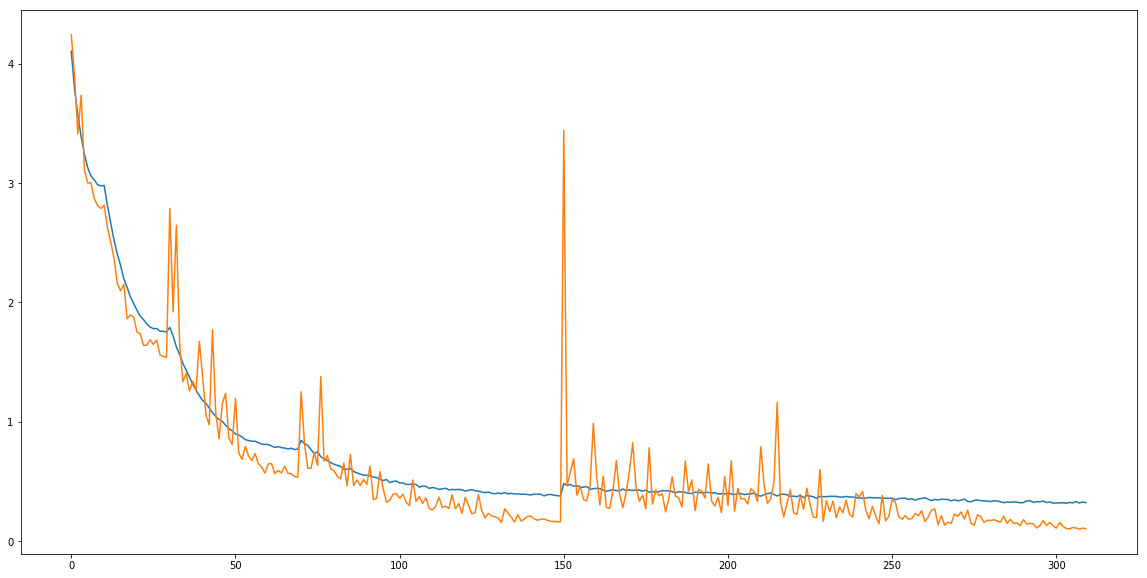

In [18]:
fig = plt.figure(figsize=(20,10))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.show()

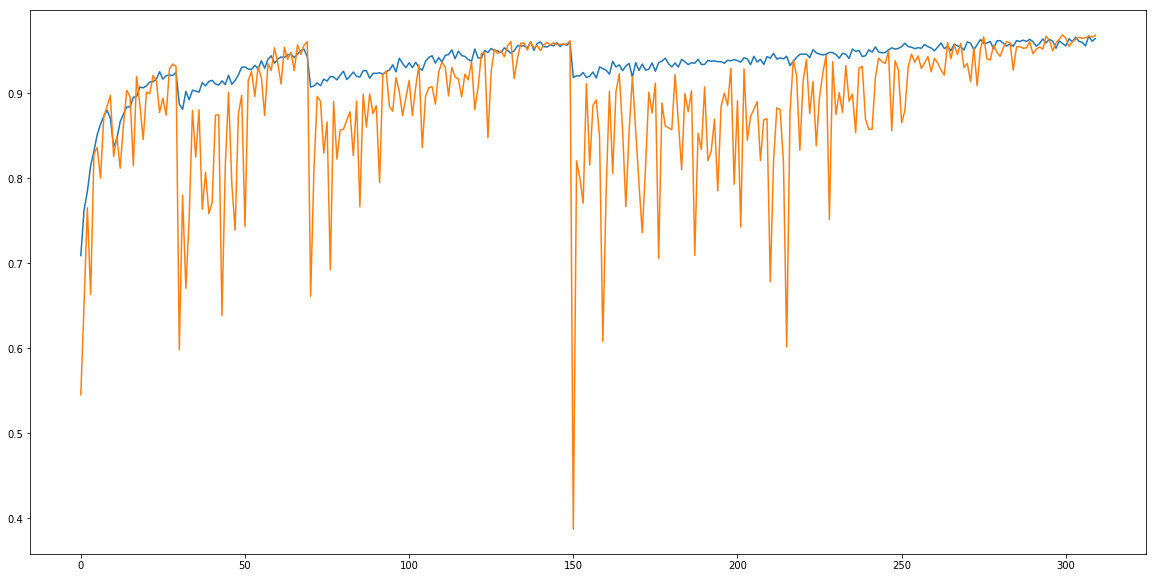

In [19]:
fig = plt.figure(figsize=(20,10))
plt.plot(model.history.history['metric_balanced_accuracy_score'])
plt.plot(model.history.history['val_metric_balanced_accuracy_score'])
plt.show()